# Capstone: Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# import project utils
import sys
sys.path.append('../src')

import data_utils
import graph_utils

## Utilities

In [3]:
# def graph_features(df, nrows, ncols, figsize=(7,7)):
#     """
#     Graph all the DataFrame columns as subplots to quickly visualize the features 
#     :param df: DataFrame to iterate on
#     :param nrows: Number of rows in subplot
#     :param ncols: Number of cols in subplot
#     :param fisize: list containing (widht, height)
#     """
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
#     # Flatten the axes array (makes it easier to iterate over)
#     axes = axes.flatten()
    
#     # Loop through each column and plot a histogram
#     for i, column in enumerate(df.columns):
        
#         # Add the histogram
#         df[column].hist(ax=axes[i], # Define on which ax we're working on
#                         edgecolor='white', # Color of the border
#                         color='#69b3a2' # Color of the bins
#                        )
        
#         # Add title and axis label
#         axes[i].set_title(f'{column}') 
#         axes[i].set_xlabel(column) 
#         axes[i].set_ylabel('Frequency') 
    
#     # Adjust layout
#     plt.tight_layout()
    
#     # Show the plot
#     plt.show()

## The Data

In [5]:
# Global settings
random_state = 42   # Consistent random_state

In [9]:
# Convert the raw SFPD data into a cleansed data file - only to be used when refreshing from new data

file_raw_data = '../data/Police_Department_Incident_Reports__2018_to_Present_20240910.csv'
file_clean_data = '../data/incidents_clean.csv'

# Uncomment to regenerate the clean data file from raw data - normally just read the clean data as it's MUCH FASTER
# data_utils.generate_clean_csv(file_raw_data, file_clean_data, debug=True)

In [11]:
# Uncomment to generate the sample files

data_utils.generate_sample_files(file_clean_data, random_state=random_state)

Start Time: 09/11/24 18:05:11

Reading file: ../data/incidents_clean.csv ... Done: 887,173 rows, 37 columns
... Writing 10% sample file: ../data/incidents_clean_10_pct.csv (88717, 37) ... Done
... Writing 25% sample file: ../data/incidents_clean_25_pct.csv (221793, 37) ... Done
... Writing 50% sample file: ../data/incidents_clean_50_pct.csv (443586, 37) ... Done
... Writing 75% sample file: ../data/incidents_clean_75_pct.csv (665380, 37) ... Done
End Time: 09/11/24 18:06:18



In [12]:
# Which dataset to work from?
sample_file_size_pct = 10
match(sample_file_size_pct):
    case 100:
        sample_file = file_clean_data
    case 25 | 50 | 75:
        file_prefix = file_clean_data.replace('.csv', '')
        sample_file = f'{file_prefix}_{sample_file_size_pct}_pct.csv'
    case _:
        sample_file = '../data/incidents_clean_10_pct.csv'

# print(sample_file)

In [13]:
clean_df = data_utils.get_clean_data_from_csv(sample_file)

Reading file: ../data/incidents_clean_10_pct.csv ... Done: 88,717 rows, 38 columns
... Converting datetime and date to timeseries ... Done
... Setting index to datetime ... Done
Done


In [14]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88717 entries, 2022-02-10 07:59:00 to 2021-07-09 00:22:00
Data columns (total 37 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Unnamed: 0                                            88717 non-null  int64         
 1   incident_datetime                                     88717 non-null  object        
 2   incident_date                                         88717 non-null  object        
 3   incident_time                                         88717 non-null  object        
 4   incident_year                                         88717 non-null  int64         
 5   incident_day_of_week                                  88717 non-null  object        
 6   report_datetime                                       88717 non-null  object        
 7   row_id                                   

In [15]:
clean_df.head(2)

,Unnamed: 0,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,row_id,incident_id,incident_number,...,point,neighborhoods,esncag_-_boundary_file,central_market/tenderloin_boundary_polygon_-_updated,civic_center_harm_reduction_project_boundary,hsoc_zones_as_of_2018-06-05,invest_in_neighborhoods_(iin)_areas,current_supervisor_districts,current_police_districts,date
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-10 07:59:00,308322,2022/02/10 07:59:00 AM,2022/02/10,07:59,2022,Thursday,2022/02/10 08:10:00 AM,112051707041,1120517,220024353,...,POINT (-122.46807726285189 37.72897476627766),67.0,NaN,NaN,NaN,NaN,NaN,8.0,10.0,2022-02-10
2022-11-17 23:30:00,371699,2022/11/17 11:30:00 PM,2022/11/17,23:30,2022,Thursday,2022/11/19 03:23:00 PM,121645375000,1216453,220797237,...,POINT (-122.42166247826907 37.76257883049033),53.0,NaN,NaN,NaN,3.0,NaN,5.0,3.0,2022-11-17


In [16]:
clean_df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Unnamed: 0,88717.0,NaN,NaN,NaN,443011.193007,0.0,220783.0,443194.0,664932.0,887170.0,256082.521158
incident_datetime,88717,77103,2021/01/01 12:00:00 AM,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incident_date,88717,2443,2019/07/26,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incident_time,88717,1440,00:00,2889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incident_year,88717.0,NaN,NaN,NaN,2020.739576,2018.0,2019.0,2021.0,2022.0,2024.0,1.939964
incident_day_of_week,88717,7,Friday,13517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
report_datetime,88717,85158,2018/06/27 07:30:00 AM,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
row_id,88717.0,NaN,NaN,NaN,102266931186.091995,61871464020.0,82325309024.0,102196709250.0,122285612030.0,142247874000.0,23117033883.249496
incident_id,88717.0,NaN,NaN,NaN,1022669.065354,618714.0,823253.0,1021967.0,1222856.0,1422478.0,231170.343796
incident_number,88717.0,NaN,NaN,NaN,208978657.440592,1819873.0,190618599.0,210249486.0,226148905.0,981081925.0,19907109.242436


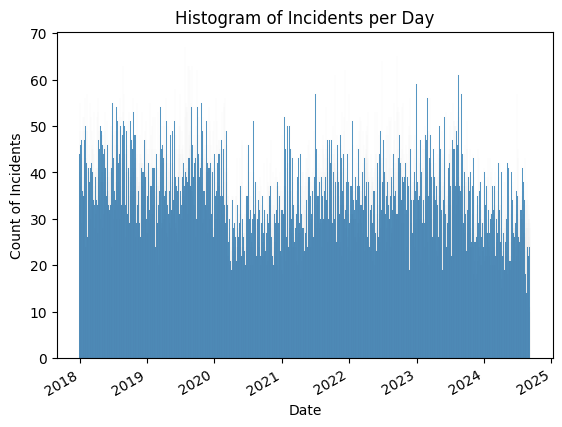

In [17]:
sns.histplot(data=clean_df, x='date', discrete=True)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Count of Incidents')
plt.title('Histogram of Incidents per Day')
plt.show()

In [18]:
clean_df.resolution.value_counts(normalize=True)

resolution
Open or Active          0.803645
Cite or Arrest Adult    0.188656
Unfounded               0.005005
Exceptional Adult       0.002694
Name: proportion, dtype: float64

In [19]:
temp_copy = clean_df.copy()

temp_copy = temp_copy.drop(columns=['report_datetime', 'row_id', 
                   'incident_id', 'incident_number', 'cad_number', 
                   'latitude', 'longitude', 'point',  'esncag_-_boundary_file',
                   'central_market/tenderloin_boundary_polygon_-_updated',
                   'civic_center_harm_reduction_project_boundary',
                   'hsoc_zones_as_of_2018-06-05', 'invest_in_neighborhoods_(iin)_areas']) 

In [20]:
temp = temp_copy.head(1000)

In [21]:
temp.columns

Index(['Unnamed: 0', 'incident_datetime', 'incident_date', 'incident_time',
       'incident_year', 'incident_day_of_week', 'report_type_code',
       'report_type_description', 'filed_online', 'incident_code',
       'incident_category', 'incident_subcategory', 'incident_description',
       'resolution', 'intersection', 'cnn', 'police_district',
       'analysis_neighborhood', 'supervisor_district',
       'supervisor_district_2012', 'neighborhoods',
       'current_supervisor_districts', 'current_police_districts', 'date'],
      dtype='object')

/Users/fazeel/Google Drive/Classroom/UCB-PCMLAI/repos/UCB_ML_AI_Capstone/notebooks/../src/graph_utils.py:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


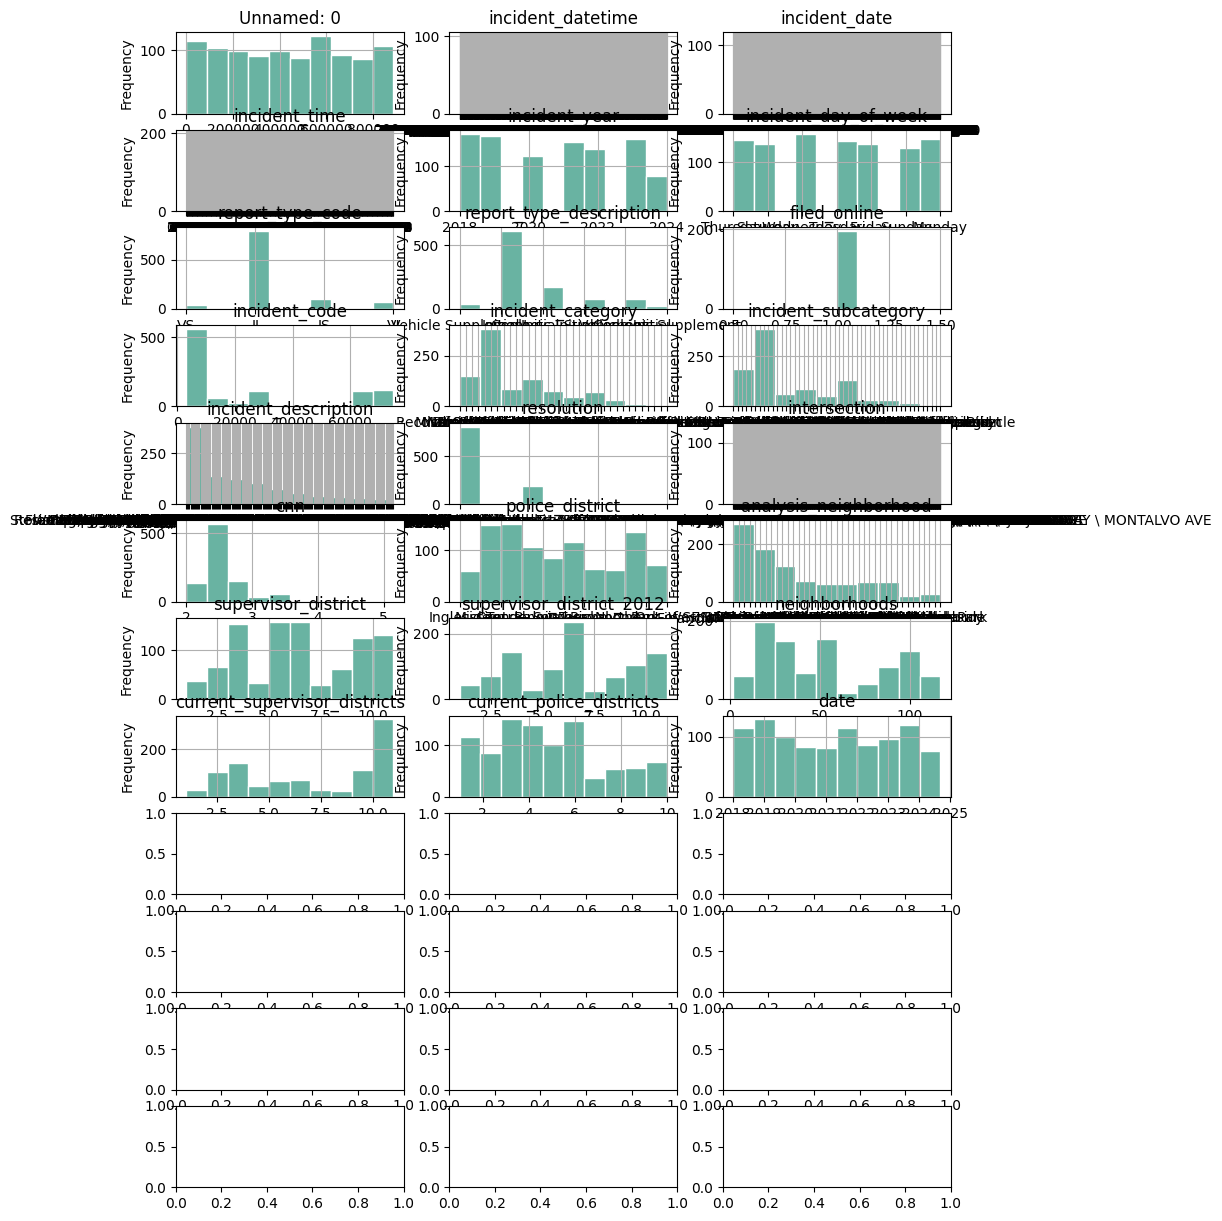

In [23]:
graph_utils.graph_features(temp, 12, 3, figsize=(10, 15))

In [24]:
# feature_df = temp[['incident_datetime', 'incident_date', 'incident_time', 'incident_year', 'incident_day_of_week']]
# graph_features(feature_df, 3, 2)

In [25]:
temp_copy.columns

Index(['Unnamed: 0', 'incident_datetime', 'incident_date', 'incident_time',
       'incident_year', 'incident_day_of_week', 'report_type_code',
       'report_type_description', 'filed_online', 'incident_code',
       'incident_category', 'incident_subcategory', 'incident_description',
       'resolution', 'intersection', 'cnn', 'police_district',
       'analysis_neighborhood', 'supervisor_district',
       'supervisor_district_2012', 'neighborhoods',
       'current_supervisor_districts', 'current_police_districts', 'date'],
      dtype='object')

In [26]:
temp_copy.incident_description.head(5)

datetime
2022-02-10 07:59:00                Vehicle, Recovered, Auto
2022-11-17 23:30:00                            Found Person
2023-12-23 22:50:00                         Found  Property
2018-09-05 13:20:00    Methamphetamine, Possession For Sale
2022-01-22 10:28:00                Vehicle, Recovered, Auto
Name: incident_description, dtype: object

In [27]:
temp_copy.shape

(88717, 24)

In [28]:
temp_copy.incident_description.value_counts()

incident_description
Theft, From Locked Vehicle, >$950            10659
Malicious Mischief, Vandalism to Property     2894
Battery                                       2693
Lost Property                                 2667
Vehicle, Stolen, Auto                         2650
                                             ...  
Homicide, Drive-by                               1
Assault, Mayhem, W/ Gun                          1
Throwing Injurious Substance on Highway          1
Loitering near ATM                               1
Assault, Att. Mayhem, W/ Force                   1
Name: count, Length: 657, dtype: int64

In [29]:
temp_copy.incident_category.value_counts()

incident_category
Larceny Theft                                   26472
Other Miscellaneous                              6039
Malicious Mischief                               5935
Assault                                          5512
Non-Criminal                                     5207
Motor Vehicle Theft                              5009
Burglary                                         4929
Recovered Vehicle                                3534
Fraud                                            2857
Warrant                                          2700
Lost Property                                    2667
Drug Offense                                     2256
Robbery                                          1945
Missing Person                                   1887
Suspicious Occ                                   1811
Disorderly Conduct                               1523
Offences Against The Family And Children         1201
Miscellaneous Investigation                      1032
Traffic Vi